<a href="https://colab.research.google.com/github/kelvinyelyen/ASR-SB/blob/main/ASR_UG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.utils import to_categorical

In [20]:
BOLD = '\033[1m'
GREEN = '\033[92m'
RESET = '\033[0m'

# Download and extract the dataset (if not already downloaded)
def download_and_extract_dataset(dataset_link, extract_to):
    if os.listdir(extract_to):
        print(f"{BOLD}{GREEN}Dataset directory is not empty. Skipping download and extraction.{RESET}")
        print(f"Files found in {extract_to}: {os.listdir(extract_to)}")
        return
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    print(f"{BOLD}{GREEN}Downloading datasets...{RESET}")
    dataset_zip_file = tf.keras.utils.get_file(os.path.basename(dataset_link), dataset_link, extract=True, cache_dir=extract_to)
    print(f"{BOLD}{GREEN}Dataset downloaded and extracted to {extract_to}.{RESET}")
    print(f"Files found in {extract_to}: {os.listdir(extract_to)}")  # Print files in the extraction directory

# Load and preprocess data
def load_and_preprocess_data(data_dir):
    audio_paths = []
    labels = []
    label_to_index = {label: i for i, label in enumerate(["yes", "no", "down", "go", "left", "right", "stop", "up"])}
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".wav"):
                audio_path = os.path.join(root, file)
                audio_paths.append(audio_path)
                label = os.path.basename(root)
                labels.append(label_to_index[label])
    print("Number of audio files found:", len(audio_paths))
    return audio_paths, labels

# Preprocess audio data (MFCC extraction)
def preprocess_audio(audio_path, sequence_length):
    audio, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    # Padding or truncating MFCCs to match the sequence length
    if mfccs.shape[1] < sequence_length:
        pad_width = sequence_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :sequence_length]
    return mfccs

In [21]:
# Build the model architecture
def build_model(input_shape, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(128, return_sequences=False),
        tf.keras.layers.Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
# Train the model
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
    return history

In [23]:
# Evaluate the model
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
    return loss, accuracy

Dataset directory is not empty. Skipping download and extraction.
Files found in data: ['mini_speech_commands.zip', '__MACOSX', 'mini_speech_commands']
Number of audio files found: 8000
Number of samples: 8000
Epoch 1/10
160/160 [==============================] - 13s 67ms/step - loss: 2.0361 - accuracy: 0.1912 - val_loss: 1.9731 - val_accuracy: 0.2406
Epoch 2/10
160/160 [==============================] - 10s 63ms/step - loss: 1.8294 - accuracy: 0.3164 - val_loss: 1.9046 - val_accuracy: 0.2594
Epoch 3/10
160/160 [==============================] - 10s 60ms/step - loss: 1.6739 - accuracy: 0.4059 - val_loss: 1.8455 - val_accuracy: 0.3039
Epoch 4/10
160/160 [==============================] - 9s 54ms/step - loss: 1.5047 - accuracy: 0.4838 - val_loss: 1.7747 - val_accuracy: 0.3414
Epoch 5/10
160/160 [==============================] - 10s 61ms/step - loss: 1.3508 - accuracy: 0.5424 - val_loss: 1.7416 - val_accuracy: 0.3453
Epoch 6/10
160/160 [==============================] - 9s 58ms/step - lo

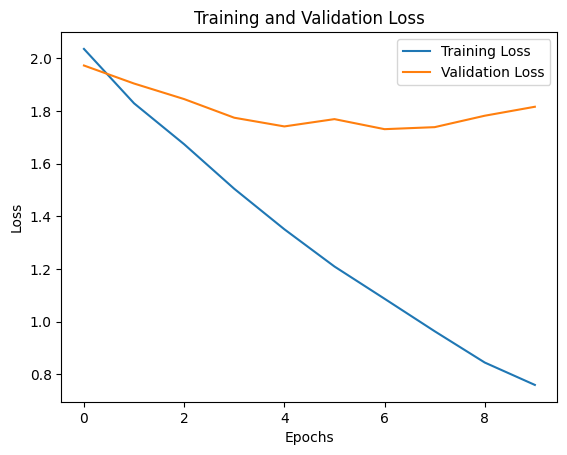

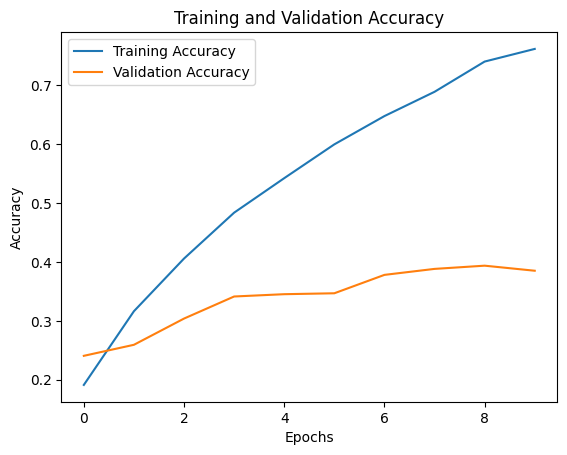

In [24]:
def main():
    dataset_link = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"
    extract_to = "data"
    data_dir = "data/mini_speech_commands"

    # Download and extract the dataset
    download_and_extract_dataset(dataset_link, extract_to)

    # Load and preprocess data
    audio_paths, labels = load_and_preprocess_data(data_dir)
    sequence_length = 1000  # Set your desired sequence length
    features = []
    for audio_path in audio_paths:
        feature = preprocess_audio(audio_path, sequence_length)
        features.append(feature)
    features = np.array(features)
    labels = np.array(labels)

    print("Number of samples:", len(features))

    # Convert labels to one-hot encoding
    num_classes = len(np.unique(labels))
    labels = to_categorical(labels, num_classes=num_classes)

    # Split data into training, validation, and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # Further split training set for validation

    # Build the model
    input_shape = features[0].shape
    model = build_model(input_shape=input_shape, output_dim=num_classes)

    # Train the model
    history = train_model(model, X_train, y_train, X_val, y_val)

    # Evaluate the model
    loss, accuracy = evaluate_model(model, X_test, y_test)

    # Visualize training/validation loss and accuracy
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()